# Project 6: Deep Dream in TensorFlow

##### 1. Load a pre-trained model (InceptionV3 without classifier).

##### 2. Select layers whose activations we want to amplify.

##### 3. Load and preprocess an image.

##### 4. Use gradient ascent to enhance the image so those layer activations increase.

##### 5. Display or save the altered image ("Deep Dream").

### Install dependencies

In [1]:
# pyright: reportMissingImports=false

import numpy as np
from functools import partial                                               # To create functions with pre-set arguments
import PIL.Image                                                            # To open, manipulate, save image files
import tensorflow as tf                                                     # Main library for building/running ML models
from tensorflow.keras.applications import InceptionV3                       # To load the pre-trained 'InceptionV3' model
from tensorflow.keras.applications.inception_v3 import preprocess_input     # To prepare images for the model
from tensorflow.keras.preprocessing import image                            # Tools to load/convert images to Tensors
import matplotlib.pyplot as plt
import urllib.request                                                       # To download file from internet
import os
import zipfile
import time

### Load the model

In [2]:
baseline_model = InceptionV3(include_top=False, weights='imagenet') # Load baseline model without top classification layer

In [3]:
# Layers inside the baseline model
for layer in baseline_model.layers:
    print(layer.name)

input_layer
conv2d
batch_normalization
activation
conv2d_1
batch_normalization_1
activation_1
conv2d_2
batch_normalization_2
activation_2
max_pooling2d
conv2d_3
batch_normalization_3
activation_3
conv2d_4
batch_normalization_4
activation_4
max_pooling2d_1
conv2d_8
batch_normalization_8
activation_8
conv2d_6
conv2d_9
batch_normalization_6
batch_normalization_9
activation_6
activation_9
average_pooling2d
conv2d_5
conv2d_7
conv2d_10
conv2d_11
batch_normalization_5
batch_normalization_7
batch_normalization_10
batch_normalization_11
activation_5
activation_7
activation_10
activation_11
mixed0
conv2d_15
batch_normalization_15
activation_15
conv2d_13
conv2d_16
batch_normalization_13
batch_normalization_16
activation_13
activation_16
average_pooling2d_1
conv2d_12
conv2d_14
conv2d_17
conv2d_18
batch_normalization_12
batch_normalization_14
batch_normalization_17
batch_normalization_18
activation_12
activation_14
activation_17
activation_18
mixed1
conv2d_22
batch_normalization_22
activation_22
co

In [4]:
# Interesting layers

layer_names = ['mixed3', 'mixed5']

layers = [baseline_model.get_layer(i).output for i in layer_names]

### Develop the dream model and maximize the loss

In [5]:
# Develop dream model

dream_model = tf.keras.Model(inputs=baseline_model.input, outputs=layers)

In [6]:
# Dream Score calculation
# Understand the process to maximize loss. Amplifies model's selected neuron activtiy.

def layer_loss(img, model): 

    img_batch = tf.expand_dims(img, axis=0) # Add a (batch) dimension to allow preprocessing
    img_batch = preprocess_input(img_batch) # Normalizes the image the same way InceptionV3 was trained

    activations = model(img_batch)

    if len(layer_names) == 1:
        activations = [activations]

    losses = [tf.reduce_mean(act) for act in activations] # calculate avg losses across all elements in layers

    return tf.reduce_sum(losses) # Get one final 'dream score' based off the averages

In [7]:
@tf.function # Allow the code to run as a TensorFlow graph for performance

def deepdream_step(img, model, step_size): # img=Image Tensor, model=Dream Model, step_size=How much to nudge the image per step

    with tf.GradientTape() as tape: # GradientTape tracks operations on img to compute the gradients

        tape.watch(img)

        loss = layer_loss(img, model) # Compute current 'dream score'

        gradients = tape.gradient(loss, img) # Compute the gradient of the loss with respect to the image

        gradients /= tf.math.reduce_std(gradients) + 1e-8

        img = img + gradients * step_size # Gradient ascent step: modifies the image in the direction that increases the loss

        img = tf.clip_by_value(img, -1.0, 1.0)

        return img, loss

### Run model

In [8]:
def run_deepdream(img, steps=100, step_size=0.01):

    img = tf.convert_to_tensor(img) # Ensures the image is a TensorFlow tensor (required for gradient tracking)

    for step in range(steps):      # Set up loop for progress tracking (every 20 steps)
        img, loss = deepdream_step(img, dream_model, step_size)

        if step % 20 == 0:
            print(f"Step {step}, Loss {loss.numpy():.4f}")

    return img                     # Final 'dreamed' image

In [9]:
def load_image(path):

    img = image.load_img(path) # Load the image from the given path using Keras

    img = image.img_to_array(img) # Converts the PIL image into a NumPy array to let Tensorflow work with it

    img = tf.image.resize(img, (224,224)) # Resize the image to 224×224 pixels, which is the input size expected by InceptionV3

    img = tf.keras.applications.inception_v3.preprocess_input(img) 
    # Preprocesses the image by scaling pixel values to the range [-1, 1], as required by InceptionV3

    return img

In [10]:
# Convert the processed image (used by the model) back to a displayable format.

def deprocess_img(img):

    img = (img + 1.0) / 2.0 # [-1, 1] -> [0, 1]

    img = np.clip(img * 255, 0, 255).astype(np.uint8) 
    # Scale the pixel values to [0, 255] -- standard RGB
    # Clip any overflow (in case of rounding) and convert to unsigned 8-bit int for image display or saving.

    return img

In [11]:
# Convert the image tensor to a NumPy array

def save_show(img_tensor, fname):

    img = deprocess_img(img_tensor.numpy())

    PIL.Image.fromarray(img).save(fname) # Convert the NumPy array to a PIL image

    plt.imshow(img)
    plt.axis('off')
    plt.title(fname)
    plt.show()

### Generate image output

Step 0, Loss 0.5097
Step 20, Loss 0.7204
Step 40, Loss 0.8491
Step 60, Loss 0.9410
Step 80, Loss 1.0068


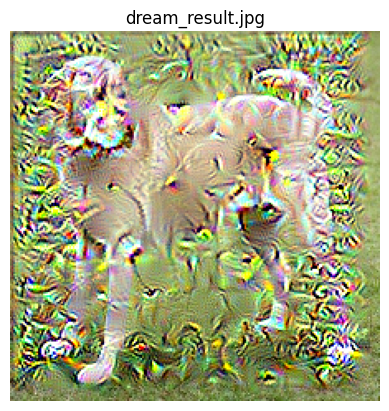

In [12]:
# Confirm that the script is running directly (and not imported as a module)
if __name__ == "__main__":
      
      input_path = tf.keras.utils.get_file('sky.jpg', 
      'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')

      original_img = load_image(input_path)

      dreamed_img = run_deepdream(original_img, steps=100, step_size=0.01) 
      # Apply 100 steps of gradient ascent to generate the Deep Dream effect

      save_show(dreamed_img, 'dream_result.jpg') # Convert the image to displayable format